In [1]:
!pip install requests
!pip install beautifulsoup4
!pip install lxml

In [9]:
import requests 
from bs4 import BeautifulSoup
import re
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
import matplotlib.pyplot as plt

## The JSON that contains all the FOMC URLs from which speech can be extracted

In [10]:
r = requests.get('https://www.federalreserve.gov/json/ne-speeches.json')

## Filtering out Speech URLs

In [11]:
def extract_FOMC_urls(html):
    url_pattern = re.compile(r'/newsevents/speech/[^\s]+.htm')
    url_list = url_pattern.findall(html)
    return url_list

In [12]:
url_list = extract_FOMC_urls(r.text)
url_list

['/newsevents/speech/barr20221201a.htm',
 '/newsevents/speech/powell20221130a.htm',
 '/newsevents/speech/cook20221130a.htm',
 '/newsevents/speech/brainard20221128a.htm',
 '/newsevents/speech/bowman20221117a.htm',
 '/newsevents/speech/jefferson20221117a.htm',
 '/newsevents/speech/waller20221116a.htm',
 '/newsevents/speech/bowman20221020a.htm',
 '/newsevents/speech/waller20221014a.htm',
 '/newsevents/speech/bowman20221012a.htm',
 '/newsevents/speech/barr20221012a.htm',
 '/newsevents/speech/brainard20221010a.htm',
 '/newsevents/speech/waller20221006a.htm',
 '/newsevents/speech/cook20221006a.htm',
 '/newsevents/speech/jefferson20221004a.htm',
 '/newsevents/speech/brainard20220930a.htm',
 '/newsevents/speech/bowman20220930a.htm',
 '/newsevents/speech/bowman20220928a.htm',
 '/newsevents/speech/powell20220928a.htm',
 '/newsevents/speech/waller20220909a.htm',
 '/newsevents/speech/barr20220907a.htm',
 '/newsevents/speech/brainard20220907a.htm',
 '/newsevents/speech/brainard20220829a.htm',
 '/ne

## Removing Invalid URLs

In [19]:
for i in url_list: 
    if i[-5] in '0123456789':
        print(i)
        url_list.remove(i)
for i in url_list: 
    if i[-13] not in '0123456789':
        print(i)
        url_list.remove(i)

/newsevents/speech/bernanke20080513.htm
/newsevents/speech/raskin20130322.htm
/newsevents/speech/tarullo20150504.htm
/newsevents/speech/fischer20150521.htm
/newsevents/speech/fischer20160519.htm
/newsevents/speech/powell20161024.htm
/newsevents/speech/kroszner2007116a.htm


## We are concerned only about the last 5 years data

In [23]:
url_list_5years=[]
for url in url_list: 
    try:
        if int(url[-13:-9]) >= 2017:
            url_list_5years.append(url)
    except ValueError as e:
        print(e)
        print(url)

In [25]:
url_list_5years

['/newsevents/speech/barr20221201a.htm',
 '/newsevents/speech/powell20221130a.htm',
 '/newsevents/speech/cook20221130a.htm',
 '/newsevents/speech/brainard20221128a.htm',
 '/newsevents/speech/bowman20221117a.htm',
 '/newsevents/speech/jefferson20221117a.htm',
 '/newsevents/speech/waller20221116a.htm',
 '/newsevents/speech/bowman20221020a.htm',
 '/newsevents/speech/waller20221014a.htm',
 '/newsevents/speech/bowman20221012a.htm',
 '/newsevents/speech/barr20221012a.htm',
 '/newsevents/speech/brainard20221010a.htm',
 '/newsevents/speech/waller20221006a.htm',
 '/newsevents/speech/cook20221006a.htm',
 '/newsevents/speech/jefferson20221004a.htm',
 '/newsevents/speech/brainard20220930a.htm',
 '/newsevents/speech/bowman20220930a.htm',
 '/newsevents/speech/bowman20220928a.htm',
 '/newsevents/speech/powell20220928a.htm',
 '/newsevents/speech/waller20220909a.htm',
 '/newsevents/speech/barr20220907a.htm',
 '/newsevents/speech/brainard20220907a.htm',
 '/newsevents/speech/brainard20220829a.htm',
 '/ne

In [26]:
for i in range(len(url_list_5years)):
    url_list_5years[i] = 'https://www.federalreserve.gov' + url_list_5years[i]

## Extracting the HTML content and the title of the webpage

In [28]:
# extract content
def extract_html_content(html):
    title = html.h3.get_text()
    content = str(html.find_all(name = 'div', class_ = 'col-xs-12 col-sm-8 col-md-8'))
    return [title, content]

In [30]:
df = pd.DataFrame(columns = ["date_of_meeting", "title", "content"])

for url in url_list_5years:

    date = url[-13:-5]

    r = requests.get(url)
    r.encoding = r.apparent_encoding
    soup = BeautifulSoup(r.text, 'lxml')
    extracted_content = extract_html_content(soup)
    

    extracted_content = [date, extracted_content[0], extracted_content[1]]
    
    df.loc[len(df)] = extracted_content

In [31]:
df

,date_of_meeting,title,content
0,20221201,Why Bank Capital Matters,"[<div class=""col-xs-12 col-sm-8 col-md-8"">\n<p..."
1,20221130,Inflation and the Labor Market,"[<div class=""col-xs-12 col-sm-8 col-md-8"">\n<p..."
2,20221130,The Economic Outlook and U.S. Productivity,"[<div class=""col-xs-12 col-sm-8 col-md-8"">\n<p..."
3,20221128,What Can We Learn from the Pandemic and the Wa...,"[<div class=""col-xs-12 col-sm-8 col-md-8"">\n<p..."
4,20221117,Financial Education,"[<div class=""col-xs-12 col-sm-8 col-md-8"">\n<p..."
...,...,...,...
339,20170119,The Economic Outlook and the Conduct of Moneta...,"[<div class=""col-xs-12 col-sm-8 col-md-8"">\n<p..."
340,20170118,The Goals of Monetary Policy and How We Pursue...,"[<div class=""col-xs-12 col-sm-8 col-md-8"">\n<p..."
341,20170117,Monetary Policy in a Time of Uncertainty,"[<div class=""col-xs-12 col-sm-8 col-md-8"">\n<p..."
342,20170112,Welcoming Remarks,"[<div class=""col-xs-12 col-sm-8 col-md-8"">\n<d..."


In [32]:
df.to_csv('./html_extract.csv') 

In [35]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

## Lets preprocess the raw content to perform sentiment analysis on it.

In [36]:

def preprocess(text):
    text = text.lower()
    text = text.strip() 
    text = re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text) 
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text)
    text = re.sub(r'\s+',' ',text)
    return text

def delete_stopwords(text):
    stop_words = set(stopwords.words('english'))
    filtered_sentence = [] 
    word_tokens = word_tokenize(text)
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    return ' '.join(filtered_sentence)

In [37]:
for i in range(len(df)):
    df.content[i] = delete_stopwords(preprocess(df.content[i]))

In [38]:
df

,date_of_meeting,title,content
0,20221201,Why Bank Capital Matters,first speech vice chair supervision september ...
1,20221130,Inflation and the Labor Market,today offer progress report federal open marke...
2,20221130,The Economic Outlook and U.S. Productivity,good morning pleasure back michigan although w...
3,20221128,What Can We Learn from the Pandemic and the Wa...,policymakers researchers begun reassessing cer...
4,20221117,Financial Education,good morning pleasure join today meeting appre...
...,...,...,...
339,20170119,The Economic Outlook and the Conduct of Moneta...,watch live privilege today discuss federal res...
340,20170118,The Goals of Monetary Policy and How We Pursue...,watch demand https www youtube com watch v ktb...
341,20170117,Monetary Policy in a Time of Uncertainty,watch many sources uncertainty affecting traje...
342,20170112,Welcoming Remarks,accessible keys video space bar toggles play p...


In [41]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...


True

In [62]:
df = df.drop('VADER',axis=1)

In [63]:
df

,date_of_meeting,title,content
0,20221201,Why Bank Capital Matters,first speech vice chair supervision september ...
1,20221130,Inflation and the Labor Market,today offer progress report federal open marke...
2,20221130,The Economic Outlook and U.S. Productivity,good morning pleasure back michigan although w...
3,20221128,What Can We Learn from the Pandemic and the Wa...,policymakers researchers begun reassessing cer...
4,20221117,Financial Education,good morning pleasure join today meeting appre...
...,...,...,...
339,20170119,The Economic Outlook and the Conduct of Moneta...,watch live privilege today discuss federal res...
340,20170118,The Goals of Monetary Policy and How We Pursue...,watch demand https www youtube com watch v ktb...
341,20170117,Monetary Policy in a Time of Uncertainty,watch many sources uncertainty affecting traje...
342,20170112,Welcoming Remarks,accessible keys video space bar toggles play p...


## Now we have just the text that we want from the HTML eliminating all other HTML special chars

## Lets use the NLTK Sentiment Analyzer Vader and the TextBlob method and compare the Hawkiness and Dovishness over the 5 years

In [64]:
sia = SentimentIntensityAnalyzer()
vader_list = []
for i in range(len(df)):
    print("Positive: ",sia.polarity_scores(df.content[i])['pos'])
    print("Negative: ",sia.polarity_scores(df.content[i])['neg'])
    print("Polarity:", sia.polarity_scores(df.content[i])['pos']-sia.polarity_scores(df.content[i])['neg'])
    vader_list.append(sia.polarity_scores(df.content[i])['pos']-sia.polarity_scores(df.content[i])['neg'])

Positive:  0.124
Negative:  0.174
Polarity: -0.04999999999999999
Positive:  0.131
Negative:  0.06
Polarity: 0.07100000000000001
Positive:  0.16
Negative:  0.051
Polarity: 0.10900000000000001
Positive:  0.084
Negative:  0.117
Polarity: -0.033
Positive:  0.229
Negative:  0.022
Polarity: 0.20700000000000002
Positive:  0.205
Negative:  0.06
Polarity: 0.145
Positive:  0.152
Negative:  0.046
Polarity: 0.106
Positive:  0.134
Negative:  0.077
Polarity: 0.05700000000000001
Positive:  0.171
Negative:  0.063
Polarity: 0.10800000000000001
Positive:  0.095
Negative:  0.08
Polarity: 0.015
Positive:  0.231
Negative:  0.081
Polarity: 0.15000000000000002
Positive:  0.129
Negative:  0.065
Polarity: 0.064
Positive:  0.127
Negative:  0.062
Polarity: 0.065
Positive:  0.133
Negative:  0.114
Polarity: 0.019000000000000003
Positive:  0.162
Negative:  0.058
Polarity: 0.10400000000000001
Positive:  0.127
Negative:  0.098
Polarity: 0.028999999999999998
Positive:  0.212
Negative:  0.094
Polarity: 0.118
Positive: 

In [66]:
df['VADER'] = vader_list

In [67]:
df

,date_of_meeting,title,content,VADER
0,20221201,Why Bank Capital Matters,first speech vice chair supervision september ...,-0.050
1,20221130,Inflation and the Labor Market,today offer progress report federal open marke...,0.071
2,20221130,The Economic Outlook and U.S. Productivity,good morning pleasure back michigan although w...,0.109
3,20221128,What Can We Learn from the Pandemic and the Wa...,policymakers researchers begun reassessing cer...,-0.033
4,20221117,Financial Education,good morning pleasure join today meeting appre...,0.207
...,...,...,...,...
339,20170119,The Economic Outlook and the Conduct of Moneta...,watch live privilege today discuss federal res...,0.046
340,20170118,The Goals of Monetary Policy and How We Pursue...,watch demand https www youtube com watch v ktb...,0.102
341,20170117,Monetary Policy in a Time of Uncertainty,watch many sources uncertainty affecting traje...,0.021
342,20170112,Welcoming Remarks,accessible keys video space bar toggles play p...,0.209


In [71]:
blob_list = []
for i in range(len(df)):
    print(TextBlob(df.content[i]).sentiment.polarity)
    blob_list.append(TextBlob(df.content[i]).sentiment.polarity)

0.07072994856825134
0.08840361885305703
0.10366902974701138
0.09244534930999015
0.11369777318640951
0.09643355919442881
0.10321374946374945
0.12324754755947416
0.05015829606078567
0.09204564049924868
0.11690535418147359
0.05756230390404697
0.07166384523388414
0.06639605084458026
0.12900974025974027
0.07137656641604008
0.11605035883275083
0.12162984660267269
0.21822344322344323
0.1523783372761069
0.0886501078136059
0.08894255901331374
0.11697146603396605
0.14155806048411682
0.07944744830202995
0.10229826839826842
0.10500866934113008
0.1111680392777954
0.07498065712867154
0.10307355723746449
0.15106008658008652
0.09602449530667348
0.08424709759937032
0.1057653260717777
0.08407629210220674
0.15073841933467594
0.19067325709116748
0.052919309729125674
0.07478667380729243
0.10603862283549785
0.1062326246187006
0.15638820638820639
0.11093380766648096
0.08975871673546094
0.07004637281910008
0.3125
0.07341359135913585
0.1164704090236006
0.10079875490866198
0.12602446164946168
0.1165103415103415

In [72]:
df['Textblob'] = blob_list

In [73]:
df

,date_of_meeting,title,content,VADER,Textblob
0,20221201,Why Bank Capital Matters,first speech vice chair supervision september ...,-0.050,0.070730
1,20221130,Inflation and the Labor Market,today offer progress report federal open marke...,0.071,0.088404
2,20221130,The Economic Outlook and U.S. Productivity,good morning pleasure back michigan although w...,0.109,0.103669
3,20221128,What Can We Learn from the Pandemic and the Wa...,policymakers researchers begun reassessing cer...,-0.033,0.092445
4,20221117,Financial Education,good morning pleasure join today meeting appre...,0.207,0.113698
...,...,...,...,...,...
339,20170119,The Economic Outlook and the Conduct of Moneta...,watch live privilege today discuss federal res...,0.046,0.081513
340,20170118,The Goals of Monetary Policy and How We Pursue...,watch demand https www youtube com watch v ktb...,0.102,0.084856
341,20170117,Monetary Policy in a Time of Uncertainty,watch many sources uncertainty affecting traje...,0.021,0.082424
342,20170112,Welcoming Remarks,accessible keys video space bar toggles play p...,0.209,0.227626


## Now lets split into separate dataframes for each of the 5 years

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date_of_meeting  344 non-null    object 
 1   title            344 non-null    object 
 2   content          344 non-null    object 
 3   VADER            344 non-null    float64
 4   Textblob         344 non-null    float64
dtypes: float64(2), object(3)
memory usage: 24.2+ KB


In [77]:
df['date_of_meeting'] = pd.to_datetime(df['date_of_meeting'])

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date_of_meeting  344 non-null    datetime64[ns]
 1   title            344 non-null    object        
 2   content          344 non-null    object        
 3   VADER            344 non-null    float64       
 4   Textblob         344 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 24.2+ KB


In [79]:
df

,date_of_meeting,title,content,VADER,Textblob
0,2022-12-01,Why Bank Capital Matters,first speech vice chair supervision september ...,-0.050,0.070730
1,2022-11-30,Inflation and the Labor Market,today offer progress report federal open marke...,0.071,0.088404
2,2022-11-30,The Economic Outlook and U.S. Productivity,good morning pleasure back michigan although w...,0.109,0.103669
3,2022-11-28,What Can We Learn from the Pandemic and the Wa...,policymakers researchers begun reassessing cer...,-0.033,0.092445
4,2022-11-17,Financial Education,good morning pleasure join today meeting appre...,0.207,0.113698
...,...,...,...,...,...
339,2017-01-19,The Economic Outlook and the Conduct of Moneta...,watch live privilege today discuss federal res...,0.046,0.081513
340,2017-01-18,The Goals of Monetary Policy and How We Pursue...,watch demand https www youtube com watch v ktb...,0.102,0.084856
341,2017-01-17,Monetary Policy in a Time of Uncertainty,watch many sources uncertainty affecting traje...,0.021,0.082424
342,2017-01-12,Welcoming Remarks,accessible keys video space bar toggles play p...,0.209,0.227626


In [80]:
df_2017 = df[(df['date_of_meeting']>'2016-12-31') & (df['date_of_meeting']<'2018-01-01')]

In [81]:
df_2017

,date_of_meeting,title,content,VADER,Textblob
289,2017-12-13,Workforce Development in Today's Economy,would like thank staff federal reserve bank ne...,0.197,0.182567
290,2017-11-30,Thoughts on Prudent Innovation in the Payment ...,pleasure today talk financial stability fintec...,0.137,0.084114
291,2017-11-16,Where Do Consumers Fit in the Fintech Stack?,new generation fintech tools offers potential ...,0.122,0.094579
292,2017-11-15,Regional Food Systems and Community Development,thank inviting appreciate opportunity listen l...,0.206,0.132005
293,2017-11-07,Remarks accepting the 2017 Paul H. Douglas Awa...,thank honor sharing award worthy person friend...,0.222,0.143380
294,2017-11-02,Introductory Remarks,good morning sorry able today frbny important ...,0.105,0.122984
295,2017-10-20,A Challenging Decade and a Question for the Fu...,delighted address national economists club als...,0.097,0.099261
296,2017-10-18,Financial Innovation: A World in Transition,live world defined rapid pace technological ch...,0.198,0.128284
297,2017-10-15,The U.S. Economy and Monetary Policy,would like thank group thirty inviting partici...,0.137,0.087845
298,2017-10-12,Rethinking Monetary Policy in a New Normal,enjoyed ben bernanke paper titled monetary pol...,0.025,0.102653


In [82]:
df_2018 = df[(df['date_of_meeting']>'2017-12-31') & (df['date_of_meeting']<'2019-01-01')]

In [83]:
df_2018

,date_of_meeting,title,content,VADER,Textblob
245,2018-12-07,Assessing Financial Stability over the Cycle,financial stability integral achieving federal...,0.013,0.081272
246,2018-12-06,Welcoming Remarks,thank kind introduction thank housing assistan...,0.167,0.121332
247,2018-12-05,Banks as Vital Infrastructure for Rural Commun...,pleasure stanford honor invited speak siepr bi...,0.131,0.051675
248,2018-12-03,Celebrating Excellence in Community Development,thank chairman powell honor introduce chair ye...,0.087,0.074706
249,2018-12-03,Celebrating Excellence in Community Development,thank anna honor part important occasion tonig...,0.258,0.143021
250,2018-12-03,The Structure of the Treasury Market: What Ar...,pleased join fourth annual conference evolving...,0.137,0.114713
251,2018-11-28,The Federal Reserve's Framework for Monitoring...,pleasure back economic club new york begin bri...,-0.031,0.093952
252,2018-11-27,Data Dependence and U.S. Monetary Policy,delighted speaking annual conference clearing ...,0.080,0.089480
253,2018-11-16,Beginning Stress Testing’s New Chapter,professor scott hosts harvard program internat...,0.000,0.095532
254,2018-11-13,What Are We Learning about Artificial Intellig...,although still early days already evident appl...,0.123,0.097535


In [84]:
df_2019 = df[(df['date_of_meeting']>'2018-12-31') & (df['date_of_meeting']<'2020-01-01')]

In [85]:
df_2019

,date_of_meeting,title,content,VADER,Textblob
167,2019-12-18,"Update on Digital Currencies, Stablecoins, and...",honored today celebrate benoît coeuré tenure e...,0.094,0.083189
168,2019-11-26,Federal Reserve Review of Monetary Policy Stra...,pleasure honor join outstanding economic resea...,0.055,0.088547
169,2019-11-25,Building on the Gains from the Long Expansion,past year colleagues federal open market commi...,0.114,0.124818
170,2019-11-14,The Federal Reserve’s Review of Its Monetary P...,delighted cato institute today participate ann...,0.071,0.091726
171,2019-11-14,Brief Remarks (via pre-recorded video),accessible keys video space bar toggles play p...,0.109,0.087534
...,...,...,...,...,...
240,2019-02-06,Inviting Participation: The Public's Role in S...,thank nan kind introduction thank president me...,0.120,0.119820
241,2019-02-06,Welcoming Remarks,thank educators us washington joining us onlin...,0.315,0.186014
242,2019-02-01,Strengthening the Community Reinvestment Act: ...,thank participating research symposium communi...,0.246,0.135410
243,2019-01-10,Monetary Policy Outlook for 2019,happy new year glad speaking new york city liv...,0.105,0.110189


In [86]:
df_2020 = df[(df['date_of_meeting']>'2019-12-31') & (df['date_of_meeting']<'2021-01-01')]

In [87]:
df_2020

,date_of_meeting,title,content,VADER,Textblob
114,2020-12-18,Strengthening the Financial System to Meet the...,want thank center american progress inviting j...,-0.017,0.069654
115,2020-12-17,Modernizing and Strengthening CRA Regulations:...,good afternoon thank inviting take part consum...,0.124,0.158401
116,2020-12-11,The Eye of Providence: Thoughts on the Evoluti...,torrential thanks partners harvard law school ...,0.099,0.083054
117,2020-12-04,Technology and the Regulatory Agenda for Commu...,thank independent community bankers america ic...,0.185,0.126107
118,2020-12-01,Modernizing and Strengthening CRA Regulations:...,good morning want thank dr helene gayle inviti...,0.144,0.094736
119,2020-11-19,The Changing Structure of Mortgage Markets and...,good afternoon everyone pleasure join today sh...,0.038,0.099388
120,2020-11-17,Strengthening Diversity and Inclusion in Econo...,pleasure today talk future economics next gene...,0.159,0.130116
121,2020-11-16,The Federal Reserve's New Framework: Context a...,vice chair clarida delivered substantially sim...,0.060,0.112746
122,2020-11-10,Modernizing and Strengthening CRA Regulations:...,good afternoon thank president fawn sharp kevi...,0.143,0.098020
123,2020-10-21,Achieving a Broad-Based and Inclusive Recovery,want express appreciation kevin daly inviting ...,0.046,0.059793


In [88]:
df_2021 = df[(df['date_of_meeting']>'2020-12-31') & (df['date_of_meeting']<'2022-01-01')]

In [89]:
df_2021

,date_of_meeting,title,content,VADER,Textblob
46,2021-12-17,A Hopeless and Imperative Endeavor: Lessons fr...,thank mike introduction privilege address fell...,0.004,0.073414
47,2021-12-02,Between the Hither and the Farther Shore: Thou...,joined board governors vice chair supervision ...,0.115,0.116470
48,2021-11-30,Federal Reserve Independence: Foundations and ...,covid pandemic mitigation efforts put place co...,0.072,0.100799
49,2021-11-29,"Engagement, Research and Policy: Integrating I...",thank bank canada invitation speak today sympo...,0.170,0.126024
50,2021-11-29,Opening Remarks,accessible keys video space bar toggles play p...,0.276,0.116510
...,...,...,...,...,...
109,2021-02-10,Getting Back to a Strong Labor Market,today discuss state labor market recent past p...,0.050,0.114769
110,2021-01-13,Full Employment in the New Monetary Policy Fr...,want thank canadian association business econo...,0.057,0.086345
111,2021-01-13,The Federal Reserve's New Framework: Context a...,august federal open market committee fomc unan...,0.032,0.078128
112,2021-01-12,Supporting Responsible Use of AI and Equitable...,today symposium use artificial intelligence ai...,0.088,0.054432


In [90]:
df_2022 = df[(df['date_of_meeting']>'2021-12-31') & (df['date_of_meeting']<'2023-01-01')]

In [91]:
df_2022

,date_of_meeting,title,content,VADER,Textblob
0,2022-12-01,Why Bank Capital Matters,first speech vice chair supervision september ...,-0.050,0.070730
1,2022-11-30,Inflation and the Labor Market,today offer progress report federal open marke...,0.071,0.088404
2,2022-11-30,The Economic Outlook and U.S. Productivity,good morning pleasure back michigan although w...,0.109,0.103669
3,2022-11-28,What Can We Learn from the Pandemic and the Wa...,policymakers researchers begun reassessing cer...,-0.033,0.092445
4,2022-11-17,Financial Education,good morning pleasure join today meeting appre...,0.207,0.113698
5,2022-11-17,Opportunity and Inclusive Economic Growth,good morning thank pleasure would like use tim...,0.145,0.096434
6,2022-11-16,The Economic Outlook and a Word of Caution on ...,thank dean kadan thank opportunity speak today...,0.106,0.103214
7,2022-10-20,Welcoming Remarks,accessible keys video space bar toggles play p...,0.057,0.123248
8,2022-10-14,The U.S. Dollar and Central Bank Digital Curre...,thank professor jackson thank harvard national...,0.108,0.050158
9,2022-10-12,Forward Guidance as a Monetary Policy Tool: Co...,thanks money marketeers inviting share perspec...,0.015,0.092046


In [92]:
normalizer = preprocessing.StandardScaler()
df.iloc[:,3:5] = normalizer.fit_transform(df.iloc[:,3:5])

In [93]:
df

,date_of_meeting,title,content,VADER,Textblob
0,2022-12-01,Why Bank Capital Matters,first speech vice chair supervision september ...,-2.236240,-0.921218
1,2022-11-30,Inflation and the Labor Market,today offer progress report federal open marke...,-0.439963,-0.469023
2,2022-11-30,The Economic Outlook and U.S. Productivity,good morning pleasure back michigan although w...,0.124156,-0.078445
3,2022-11-28,What Can We Learn from the Pandemic and the Wa...,policymakers researchers begun reassessing cer...,-1.983871,-0.365612
4,2022-11-17,Financial Education,good morning pleasure join today meeting appre...,1.578992,0.178149
...,...,...,...,...,...
339,2017-01-19,The Economic Outlook and the Conduct of Moneta...,watch live privilege today discuss federal res...,-0.811095,-0.645328
340,2017-01-18,The Goals of Monetary Policy and How We Pursue...,watch demand https www youtube com watch v ktb...,0.020240,-0.559799
341,2017-01-17,Monetary Policy in a Time of Uncertainty,watch many sources uncertainty affecting traje...,-1.182227,-0.622023
342,2017-01-12,Welcoming Remarks,accessible keys video space bar toggles play p...,1.608683,3.093099


In [94]:
df_2017 = df[(df['date_of_meeting']>'2016-12-31') & (df['date_of_meeting']<'2018-01-01')]
df_2018 = df[(df['date_of_meeting']>'2017-12-31') & (df['date_of_meeting']<'2019-01-01')]
df_2019 = df[(df['date_of_meeting']>'2018-12-31') & (df['date_of_meeting']<'2020-01-01')]
df_2020 = df[(df['date_of_meeting']>'2019-12-31') & (df['date_of_meeting']<'2021-01-01')]
df_2021 = df[(df['date_of_meeting']>'2020-12-31') & (df['date_of_meeting']<'2022-01-01')]
df_2022 = df[(df['date_of_meeting']>'2021-12-31') & (df['date_of_meeting']<'2023-01-01')]

In [95]:
df_2017

,date_of_meeting,title,content,VADER,Textblob
289,2017-12-13,Workforce Development in Today's Economy,would like thank staff federal reserve bank ne...,1.430539,1.940227
290,2017-11-30,Thoughts on Prudent Innovation in the Payment ...,pleasure today talk financial stability fintec...,0.539824,-0.578770
291,2017-11-16,Where Do Consumers Fit in the Fintech Stack?,new generation fintech tools offers potential ...,0.317145,-0.311018
292,2017-11-15,Regional Food Systems and Community Development,thank inviting appreciate opportunity listen l...,1.564147,0.646544
293,2017-11-07,Remarks accepting the 2017 Paul H. Douglas Awa...,thank honor sharing award worthy person friend...,1.801671,0.937605
294,2017-11-02,Introductory Remarks,good morning sorry able today frbny important ...,0.064775,0.415740
295,2017-10-20,A Challenging Decade and a Question for the Fu...,delighted address national economists club als...,-0.053987,-0.191232
296,2017-10-18,Financial Innovation: A World in Transition,live world defined rapid pace technological ch...,1.445385,0.551340
297,2017-10-15,The U.S. Economy and Monetary Policy,would like thank group thirty inviting partici...,0.539824,-0.483320
298,2017-10-12,Rethinking Monetary Policy in a New Normal,enjoyed ben bernanke paper titled monetary pol...,-1.122846,-0.104431


In [96]:
df = df.sort_index(ascending = False)

In [97]:
df

,date_of_meeting,title,content,VADER,Textblob
343,2017-01-07,Low Interest Rates and the Financial System,thank invitation discuss low interest rates fi...,-1.048619,-1.117356
342,2017-01-12,Welcoming Remarks,accessible keys video space bar toggles play p...,1.608683,3.093099
341,2017-01-17,Monetary Policy in a Time of Uncertainty,watch many sources uncertainty affecting traje...,-1.182227,-0.622023
340,2017-01-18,The Goals of Monetary Policy and How We Pursue...,watch demand https www youtube com watch v ktb...,0.020240,-0.559799
339,2017-01-19,The Economic Outlook and the Conduct of Moneta...,watch live privilege today discuss federal res...,-0.811095,-0.645328
...,...,...,...,...,...
4,2022-11-17,Financial Education,good morning pleasure join today meeting appre...,1.578992,0.178149
3,2022-11-28,What Can We Learn from the Pandemic and the Wa...,policymakers researchers begun reassessing cer...,-1.983871,-0.365612
2,2022-11-30,The Economic Outlook and U.S. Productivity,good morning pleasure back michigan although w...,0.124156,-0.078445
1,2022-11-30,Inflation and the Labor Market,today offer progress report federal open marke...,-0.439963,-0.469023


## Lets look at the progression of gawkiness and dovishness for 2017

C:\Users\rahul\AppData\Local\Temp/ipykernel_16812/1191964260.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".-r" (-> color='r'). The keyword argument will take precedence.
  plt.plot(X,k1,'.-r',label = "VADER",color="blue")
C:\Users\rahul\AppData\Local\Temp/ipykernel_16812/1191964260.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".-y" (-> color='y'). The keyword argument will take precedence.
  plt.plot(X,k2,'.-y',label = "Textblob",color="pink")


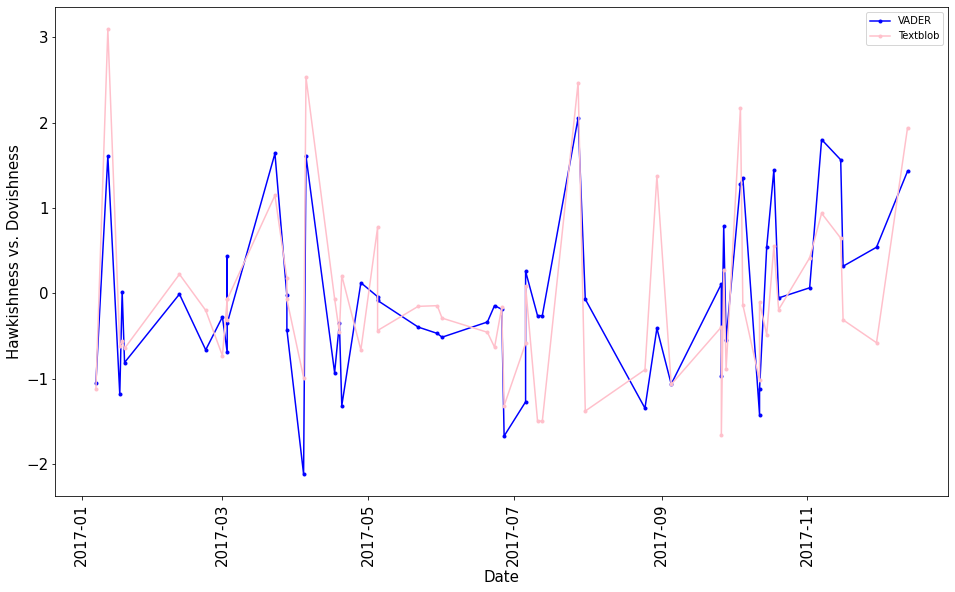

In [112]:
# plot
plt.figure(figsize=(16, 9))
X = df_2017.date_of_meeting
k1 = df_2017.VADER
k2 = df_2017.Textblob
plt.plot(X,k1,'.-r',label = "VADER",color="blue")
plt.plot(X,k2,'.-y',label = "Textblob",color="pink")
plt.xlabel("Date", size = 15)
plt.ylabel("Hawkishness vs. Dovishness", size = 15)
plt.legend(loc = "best")
plt.xticks(rotation = 90)
plt.tick_params(axis = "both", labelsize = 15)
plt.show()


## It can be seen that the market has been fairly dovish or neutral for most parts of 2017 except for a certain period between march and April during which it seems to be very Hawkish. This was before the pandemic happened and most of the economy was not sliding down or up too much.

C:\Users\rahul\AppData\Local\Temp/ipykernel_16812/2504003912.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".-r" (-> color='r'). The keyword argument will take precedence.
  plt.plot(X,k1,'.-r',label = "VADER",color="blue")
C:\Users\rahul\AppData\Local\Temp/ipykernel_16812/2504003912.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".-y" (-> color='y'). The keyword argument will take precedence.
  plt.plot(X,k2,'.-y',label = "Textblob",color="pink")


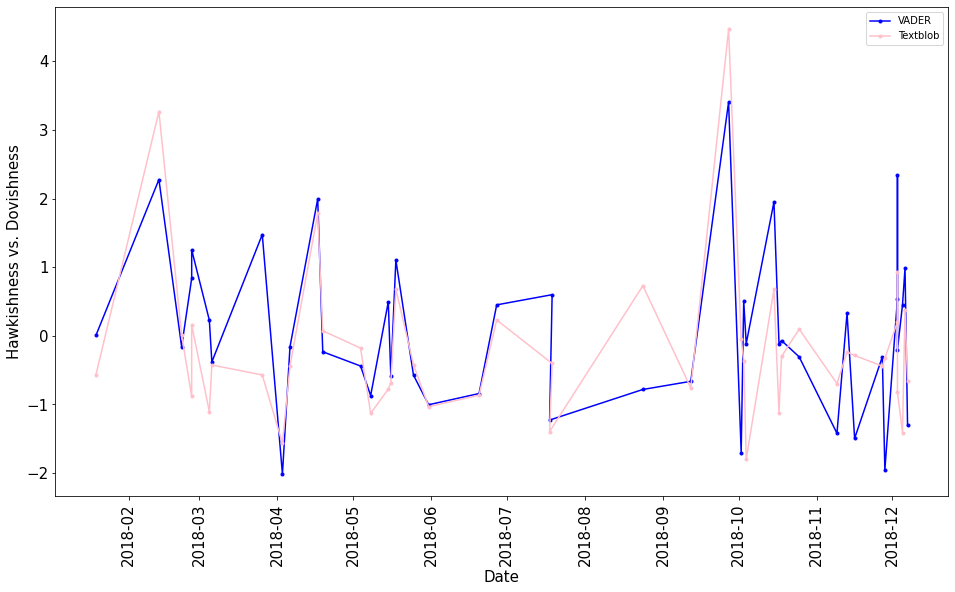

In [111]:
# plot
plt.figure(figsize=(16, 9))
X = df_2018.date_of_meeting
k1 = df_2018.VADER
k2 = df_2018.Textblob
plt.plot(X,k1,'.-r',label = "VADER",color="blue")
plt.plot(X,k2,'.-y',label = "Textblob",color="pink")
plt.xlabel("Date", size = 15)
plt.ylabel("Hawkishness vs. Dovishness", size = 15)
plt.legend(loc = "best")
plt.xticks(rotation = 90)
plt.tick_params(axis = "both", labelsize = 15)
plt.show()

## The situation during 2018 looks fairly similar to 2017 except for some extra hawkishness when compared to 2017

C:\Users\rahul\AppData\Local\Temp/ipykernel_16812/465913917.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".-r" (-> color='r'). The keyword argument will take precedence.
  plt.plot(X,k1,'.-r',label = "VADER",color="blue")
C:\Users\rahul\AppData\Local\Temp/ipykernel_16812/465913917.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".-y" (-> color='y'). The keyword argument will take precedence.
  plt.plot(X,k2,'.-y',label = "Textblob",color="pink")


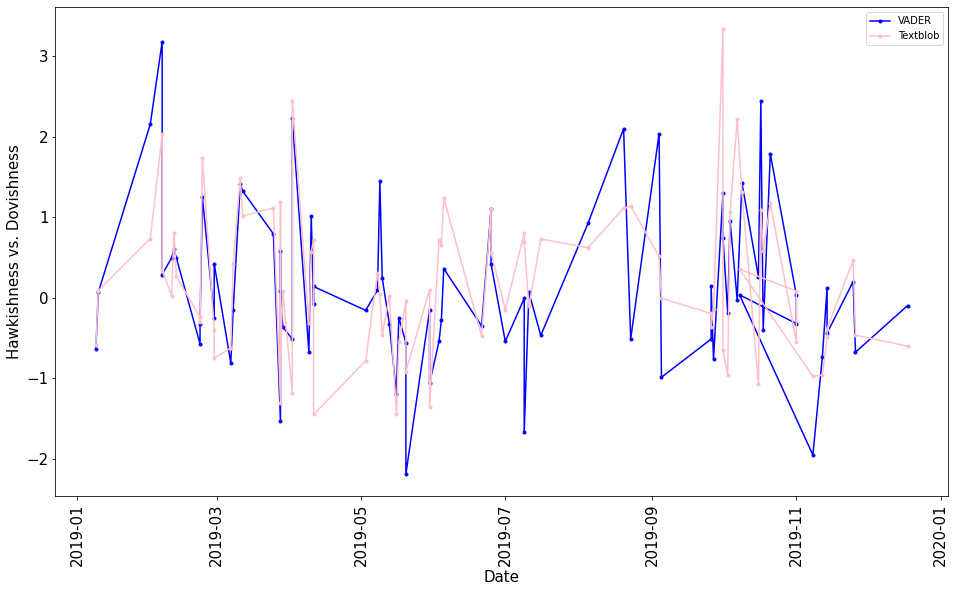

In [110]:
plt.figure(figsize=(16, 9))
X = df_2019.date_of_meeting
k1 = df_2019.VADER
k2 = df_2019.Textblob
plt.plot(X,k1,'.-r',label = "VADER",color="blue")
plt.plot(X,k2,'.-y',label = "Textblob",color="pink")
plt.xlabel("Date", size = 15)
plt.ylabel("Hawkishness vs. Dovishness", size = 15)
plt.legend(loc = "best")
plt.xticks(rotation = 90)
plt.tick_params(axis = "both", labelsize = 15)
plt.show()

C:\Users\rahul\AppData\Local\Temp/ipykernel_16812/1670194894.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".-r" (-> color='r'). The keyword argument will take precedence.
  plt.plot(X,k1,'.-r',label = "VADER",color="blue")
C:\Users\rahul\AppData\Local\Temp/ipykernel_16812/1670194894.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".-y" (-> color='y'). The keyword argument will take precedence.
  plt.plot(X,k2,'.-y',label = "Textblob",color="pink")


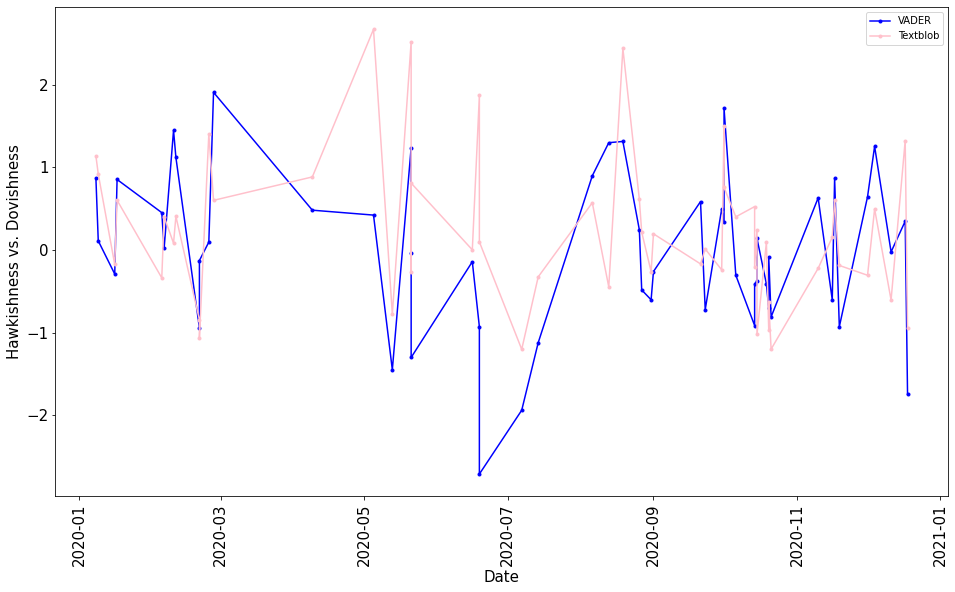

In [109]:
plt.figure(figsize=(16, 9))
X = df_2020.date_of_meeting
k1 = df_2020.VADER
k2 = df_2020.Textblob
plt.plot(X,k1,'.-r',label = "VADER",color="blue")
plt.plot(X,k2,'.-y',label = "Textblob",color="pink")
plt.xlabel("Date", size = 15)
plt.ylabel("Hawkishness vs. Dovishness", size = 15)
plt.legend(loc = "best")
plt.xticks(rotation = 90)
plt.tick_params(axis = "both", labelsize = 15)
plt.show()

C:\Users\rahul\AppData\Local\Temp/ipykernel_16812/4097240016.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".-r" (-> color='r'). The keyword argument will take precedence.
  plt.plot(X,k1,'.-r',label = "VADER",color="blue")
C:\Users\rahul\AppData\Local\Temp/ipykernel_16812/4097240016.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".-y" (-> color='y'). The keyword argument will take precedence.
  plt.plot(X,k2,'.-y',label = "Textblob",color="pink")


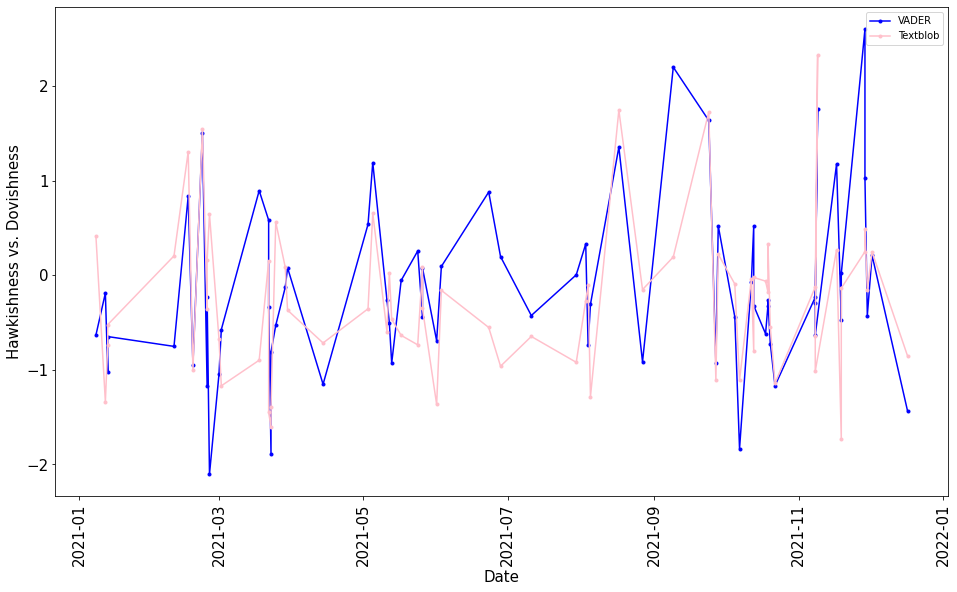

In [108]:
plt.figure(figsize=(16, 9))
X = df_2021.date_of_meeting
k1 = df_2021.VADER
k2 = df_2021.Textblob
plt.plot(X,k1,'.-r',label = "VADER",color="blue")
plt.plot(X,k2,'.-y',label = "Textblob",color="pink")
plt.xlabel("Date", size = 15)
plt.ylabel("Hawkishness vs. Dovishness", size = 15)
plt.legend(loc = "best")
plt.xticks(rotation = 90)
plt.tick_params(axis = "both", labelsize = 15)
plt.show()

## It can be seen that 2020 and 2021 have predominantely been towards the dovishness side especially during the later part of 2021 when the pandemic was extremely rampant and interest rates where going fairly down.

C:\Users\rahul\AppData\Local\Temp/ipykernel_16812/1306241583.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".-r" (-> color='r'). The keyword argument will take precedence.
  plt.plot(X,k1,'.-r',label = "VADER",color="blue")
C:\Users\rahul\AppData\Local\Temp/ipykernel_16812/1306241583.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".-y" (-> color='y'). The keyword argument will take precedence.
  plt.plot(X,k2,'.-y',label = "Textblob",color="pink")


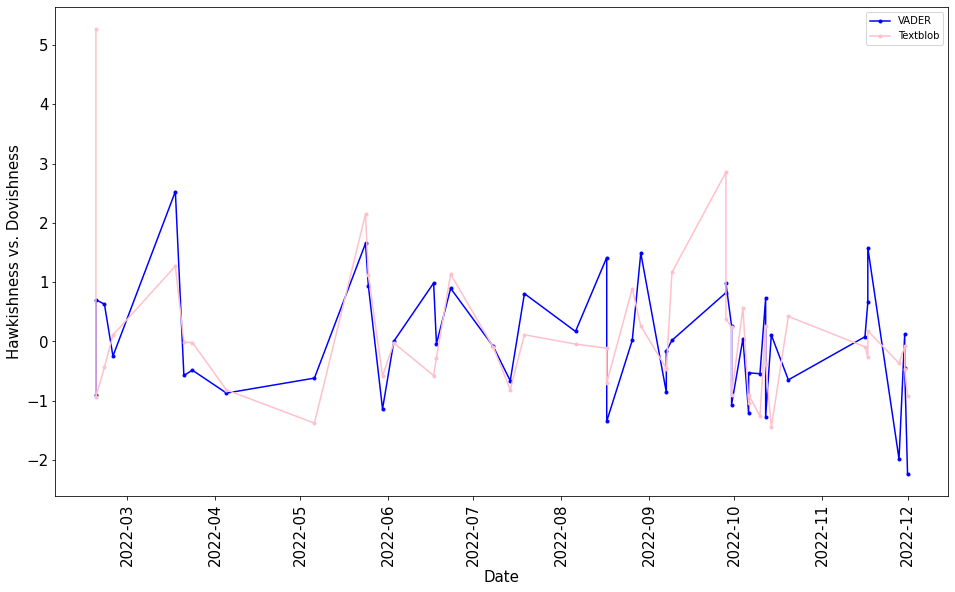

In [107]:
plt.figure(figsize=(16, 9))
X = df_2022.date_of_meeting
k1 = df_2022.VADER
k2 = df_2022.Textblob
plt.plot(X,k1,'.-r',label = "VADER",color="blue")
plt.plot(X,k2,'.-y',label = "Textblob",color="pink")
plt.xlabel("Date", size = 15)
plt.ylabel("Hawkishness vs. Dovishness", size = 15)
plt.legend(loc = "best")
plt.xticks(rotation = 90)
plt.tick_params(axis = "both", labelsize = 15)
plt.show()

## It can be clearly seen that in 2022, especially towards the later part of the year, the sentiment has been extremely Hawkish. This is because the interest rates were high, we had high attrition rates and unemployment. The currency also weakened and moved towards a state of inflation.

In [115]:
print(df_2018['VADER'].mean())

0.05262927576004956


In [116]:
print(df_2019['VADER'].mean())

0.147185630833172


In [121]:
print(df_2021['VADER'].mean())

-0.1332341887743233


In [119]:
print(df_2022['VADER'].mean())

-0.005255507674546375


## Observations

## Lets first understand what is Hawkishness vs Dovishness. 

## Hawkishness is when people are extra defensive and negative. The amount of 
## currency printed gets lesser. The interest rates go up and investments go down. When investments go down demand goes down and we
## we have not much of work to do and so there is unemployment and signs of inflation.

## On the other hand Dovishness is when people are very positive. A lot more currency is printed. And so there is a lot more money lended
## for lower interest rates. So people tend to have more money and they invest more. When they invest more the demands becomes higher. With
## higher demands jobs get created and until attaining this saturation point, markets tend to grow as much as possible.

## From our sentimental analysis on the FOMC minutes of meeting speech text over the period of 2017-2022, it can clearly be seen as 3 distinct phases
## The pre pandemic phase, the pandemic phase and the post pandemic phase. The pre pandemic phase was the phase where countries were growing rapidly
## especially the US in terms of economy. The unmeployment rates were pushed down and the interest rates where low. And so the overall sentiment during 2017-2019
## has been dovish. This is pre pandemic era. During the pandemic, economies slipped until the vaccines were rolled out and post vaccination
## economies simply sky rocketed because of a heavy demand for goods and services. The later parts of 2021 and the early parts of 2022 lean towards the
## hawkishness sentiment. Whereas the recent 6 to 7 months which is the 3rd period has seen over saturation of cash flow and hence lack of demand and hence
## increased interest rates and lessened investments and workforce. Which is basically signs of inflation and negative sentiments that is hawkishness.
## And this can be seen in the later half of 2022.